# Comparaison model métier (Signal_Model_Compar) vs model baseline (Signal_Baseline_Model_v2)

## 1 - IMPORTS + CHARGEMENT DES DF

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

In [188]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set path to datasets
DATA_DIR = Path('../src/ose_core/data_ingestion/extracted_datasets')

print("Libraries imported successfully!")

Libraries imported successfully!


In [189]:
# Load signals data
df_signals = pd.read_csv(DATA_DIR / '08_signals.csv', dtype={'siren': str, 'siret': str})

print(f"Dataset shape: {df_signals.shape}")
print(f"\nColumns: {list(df_signals.columns)}")
display(df_signals.head(3))

Dataset shape: (2133, 12)

Columns: ['company_name', 'siren', 'siret', 'continent', 'country', 'departement', 'publishedAt', 'isMain', 'type', 'createdAt', 'companies_count', 'sirets_count']


,company_name,siren,siret,continent,country,departement,publishedAt,isMain,type,createdAt,companies_count,sirets_count
0,PAIN D'EPICES MULOT ET PETITJEAN,015751530,01575153000013,"[{'id': 6, 'label': 'Europe'}]","[{'id': 72, 'label': 'France'}]","[{'parent': 'Bourgogne-Franche-Comté', 'id': 2...",2021-09-30T00:00:00+02:00,True,"{'code': 'K1', 'id': 32, 'label': 'Investissem...",2020-09-07T15:14:38+02:00,1,1
1,PAIN D'EPICES MULOT ET PETITJEAN,015751530,01575153000013,"[{'id': 6, 'label': 'Europe'}]","[{'id': 72, 'label': 'France'}]","[{'parent': 'Bourgogne-Franche-Comté', 'id': 2...",2020-09-08T00:00:00+02:00,True,"{'code': 'L', 'id': 12, 'label': 'Levée de fon...",2020-09-07T15:14:12+02:00,1,1
2,PAIN D'EPICES MULOT ET PETITJEAN,015751530,01575153000013,NaN,NaN,NaN,2016-09-21T00:00:00+02:00,True,"{'code': 'F', 'id': 6, 'label': ""Développement...",2016-09-20T10:45:13+02:00,1,1


In [190]:
# Summary
print(f"\nSignals Summary:")
print(f"Total signal records: {len(df_signals)}")
print(f"Unique companies with signals: {df_signals['siren'].nunique()}")
print(f"Average signals per company: {len(df_signals) / df_signals['siren'].nunique():.1f}")
print(f"\nSignal types:")
if 'type' in df_signals.columns:
    print(df_signals['type'].value_counts().head(10))
print(f"\nCountries:")
if 'country' in df_signals.columns:
    print(df_signals['country'].value_counts().head(10))


Signals Summary:
Total signal records: 2133
Unique companies with signals: 266
Average signals per company: 8.0

Signal types:
type
{'code': 'B', 'id': 2, 'label': 'Construction'}                                       309
{'code': 'K1', 'id': 32, 'label': 'Investissements'}                                  282
{'code': 'N', 'id': 14, 'label': 'Recrutement'}                                       214
{'code': 'L', 'id': 12, 'label': 'Levée de fonds, financements & modifs. capital'}    205
{'code': 'F', 'id': 6, 'label': "Développement de l'activité"}                        193
{'code': 'Hbis', 'id': 24, 'label': 'Activité internationale (industrie)'}            129
{'code': 'P', 'id': 16, 'label': 'Vente & Cession'}                                   105
{'code': 'S', 'id': 19, 'label': 'Lancement'}                                          87
{'code': 'E', 'id': 5, 'label': 'Créations & ouvertures'}                              63
{'code': 'U', 'id': 21, 'label': 'Nomination'}           

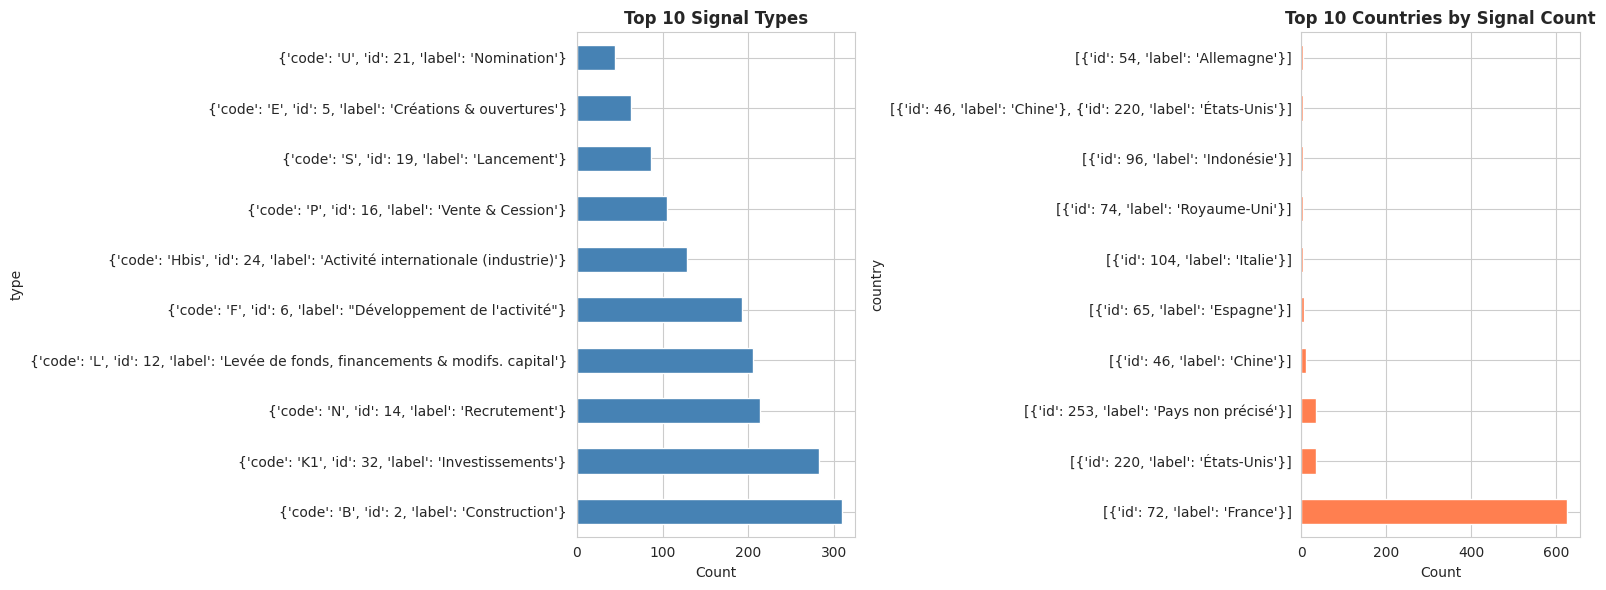

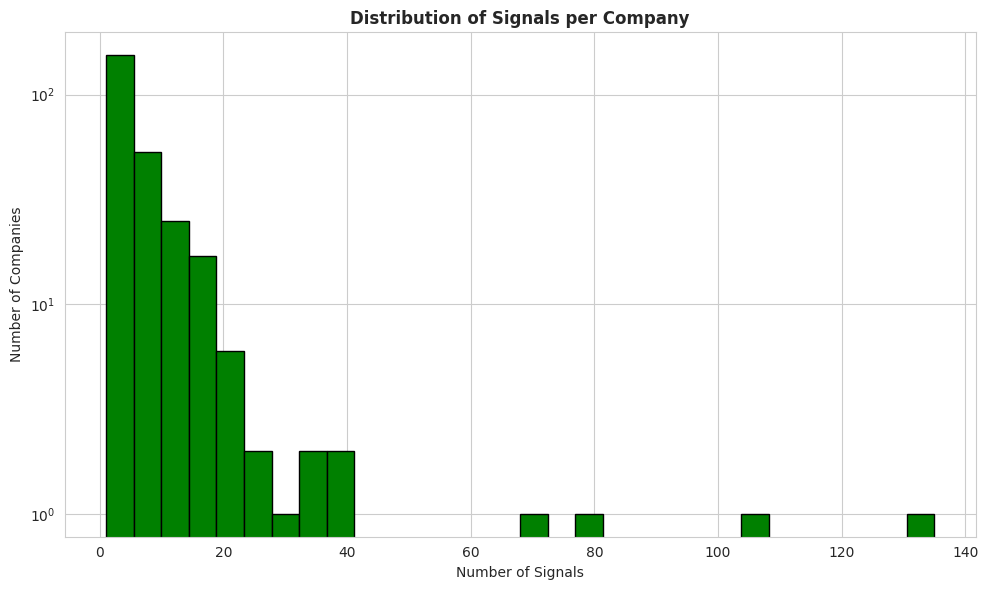

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Signal types
if 'type' in df_signals.columns:
    signal_types = df_signals['type'].value_counts().head(10)
    signal_types.plot(kind='barh', ax=axes[0], color='steelblue')
    axes[0].set_title('Top 10 Signal Types', fontweight='bold')
    axes[0].set_xlabel('Count')

# Countries
if 'country' in df_signals.columns:
    countries = df_signals['country'].value_counts().head(10)
    countries.plot(kind='barh', ax=axes[1], color='coral')
    axes[1].set_title('Top 10 Countries by Signal Count', fontweight='bold')
    axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

# Signals per company distribution
signals_per_company = df_signals.groupby('siren').size()
plt.figure(figsize=(10, 6))
signals_per_company.hist(bins=30, color='green', edgecolor='black')
plt.title('Distribution of Signals per Company', fontweight='bold')
plt.xlabel('Number of Signals')
plt.ylabel('Number of Companies')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [192]:
df_sig = df_signals.copy()

In [193]:
#nettoyage
#transfo date
def to_datetime_robust(series):
    """
    Convertit une série en datetime en gérant :
    - timestamps numériques (en secondes)
    - strings '2024-01-01T...' ou similaires
    """
    if np.issubdtype(series.dtype, np.number):
        return pd.to_datetime(series, unit="s", errors="coerce")
    else:
        return pd.to_datetime(series, errors="coerce")

In [194]:
# SIREN en string
df_sig["siren"] = df_sig["siren"].astype(str)


df_sig["publishedAt_dt"] = to_datetime_robust(df_sig["publishedAt"])
df_sig["createdAt_dt"]   = to_datetime_robust(df_sig["createdAt"])

# Date du signal : priorité publishedAt, sinon createdAt
df_sig["sig_date"] = df_sig["publishedAt_dt"].fillna(df_sig["createdAt_dt"])

# (optionnel mais propre) : enlever les lignes sans date exploitable
df_sig = df_sig[~df_sig["sig_date"].isna()].copy()

# Petit check
display(df_sig['type'].value_counts().head(10))
display(df_sig[["siren", "type", "sig_date"]].head())

/tmp/ipykernel_5305/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")
/tmp/ipykernel_5305/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")


type
{'code': 'B', 'id': 2, 'label': 'Construction'}                                       309
{'code': 'K1', 'id': 32, 'label': 'Investissements'}                                  282
{'code': 'N', 'id': 14, 'label': 'Recrutement'}                                       214
{'code': 'L', 'id': 12, 'label': 'Levée de fonds, financements & modifs. capital'}    205
{'code': 'F', 'id': 6, 'label': "Développement de l'activité"}                        193
{'code': 'Hbis', 'id': 24, 'label': 'Activité internationale (industrie)'}            129
{'code': 'P', 'id': 16, 'label': 'Vente & Cession'}                                   105
{'code': 'S', 'id': 19, 'label': 'Lancement'}                                          87
{'code': 'E', 'id': 5, 'label': 'Créations & ouvertures'}                              63
{'code': 'U', 'id': 21, 'label': 'Nomination'}                                         45
Name: count, dtype: int64

,siren,type,sig_date
0,015751530,"{'code': 'K1', 'id': 32, 'label': 'Investissem...",2021-09-30 00:00:00+02:00
1,015751530,"{'code': 'L', 'id': 12, 'label': 'Levée de fon...",2020-09-08 00:00:00+02:00
2,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2016-09-21 00:00:00+02:00
3,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2018-04-06 00:00:00+02:00
4,015751530,"{'code': 'E', 'id': 5, 'label': 'Créations & o...",2018-04-06 00:00:00+02:00


In [195]:
def normalize_type(type_str):
    """
    À partir d'une chaîne du type "{'code': 'L', 'label_short': ..., 'id': 12, 'label': ...}",
    retourne un identifiant unique basé uniquement sur code + id + label.
    """
    try:
        d = ast.literal_eval(type_str)  # convertir la string en dict
        code = d.get("code")
        type_id = d.get("id")
        label = d.get("label")
        return f"{code}_{type_id}_{label}"
    except:
        return None

df_sig["type_normalized"] = df_sig["type"].apply(normalize_type)

In [196]:
df_pivot = (
    df_sig
      .groupby(["siren", "type_normalized"])
      .size()
      .reset_index(name="count")
      .pivot(index="siren", columns="type_normalized", values="count")
      .fillna(0)
)

df_pivot.head(5)

type_normalized,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,H_8_Activité internationale (tertiaire),...,R_18_Décroissance,S_19_Lancement,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda
siren,,,,,,,,,,,,,,,,,,,,,
015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### model baseline

In [197]:
# diversité des signaux
df_pivot["diversite_signaux"] = (df_pivot > 0).sum(axis=1)
#print(df_pivot["diversite_signaux"].head)

In [198]:
df_recency = (
    df_sig
      .groupby("siren")["sig_date"]
      .max()
      .reset_index()
      .rename(columns={"sig_date": "last_signal_date"})
)
df_recency.head(5)

,siren,last_signal_date
0,015751530,2025-03-03 00:15:21+01:00
1,046580031,2022-08-08 00:00:00+02:00
2,057504649,2024-06-16 00:00:00+02:00
3,086781150,2023-06-29 00:00:00+02:00
4,096780838,2024-03-11 00:00:00+01:00


In [199]:
# date signal la plus récente
reference_date = df_recency["last_signal_date"].max()
reference_date

Timestamp('2025-11-19 00:15:35+0100', tz='UTC+01:00')

In [200]:
df_recency["last_signal_date"] = pd.to_datetime(
    df_recency["last_signal_date"],
    errors="coerce"
)

# Delta en jours
df_recency["recency_jours"] = (reference_date - df_recency["last_signal_date"]).dt.days

df_recency["recency_jours"].head(5)

0    261.0
1      NaN
2      NaN
3      NaN
4    618.0
Name: recency_jours, dtype: float64

In [201]:
# merge signaux et recency par siren pour le model
df_model = df_pivot.merge(df_recency[["siren", "recency_jours"]], on="siren", how="left")
# dégager les NaN dans recency
df_model["recency_jours"] = df_model["recency_jours"].fillna(df_model["recency_jours"].max())
df_model.head()

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda,diversite_signaux,recency_jours
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,261.0
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4017.0
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4017.0
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4017.0
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5,618.0


In [202]:
# S'assurer que sig_date est bien au format datetime
df_sig["sig_date"] = pd.to_datetime(df_sig["sig_date"], errors="coerce")

# virer les lignes qui n'ont toujours pas de date exploitable
df_sig = df_sig[~df_sig["sig_date"].isna()].copy()

# nouvelle info mois
df_sig["month"] = df_sig["sig_date"].dt.to_period("M")
last_month = df_sig["month"].max()
three_months_ago = last_month - 2  # last month, -1, -2 = 3 mois
twelve_months_ago = last_month - 11
two_years_ago = last_month - 23
tree_years_ago = last_month - 35
four_years_ago = last_month - 47
five_years_ago = last_month - 59
six_years_ago = last_month - 71
seven_years_ago = last_month - 83
eight_years_ago = last_month - 95
nine_years_ago = last_month - 107
ten_years_ago = last_month - 119
print(f"Last month : {last_month}, 3 months ago: {three_months_ago}, 1 year ago: {twelve_months_ago}, 2 years ago: {two_years_ago}, 3 years ago: {tree_years_ago}, 4 years ago: {four_years_ago}, 5 years ago: {five_years_ago}, 6 years ago: {six_years_ago}, 7 years ago: {seven_years_ago}, 8 years ago: {eight_years_ago}, 9 years ago: {nine_years_ago}, 10 years ago: {ten_years_ago}")

Last month : 2025-10, 3 months ago: 2025-08, 1 year ago: 2024-11, 2 years ago: 2023-11, 3 years ago: 2022-11, 4 years ago: 2021-11, 5 years ago: 2020-11, 6 years ago: 2019-11, 7 years ago: 2018-11, 8 years ago: 2017-11, 9 years ago: 2016-11, 10 years ago: 2015-11


/tmp/ipykernel_5305/886761737.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_sig["month"] = df_sig["sig_date"].dt.to_period("M")


In [203]:
# signaux 1 mois
df_1m = df_sig[df_sig["month"] == last_month]
df_1m = df_1m.groupby("siren").size().reset_index(name="nb_signaux_1m")
# signaux 3 mois
df_3m = df_sig[(df_sig["month"] >= three_months_ago) & (df_sig["month"] <= last_month)]
df_3m = df_3m.groupby("siren").size().reset_index(name="nb_signaux_3m")
# signaux 12 mois
df_12m = df_sig[(df_sig["month"] >= twelve_months_ago) & (df_sig["month"] <= three_months_ago)]
df_12m = df_12m.groupby("siren").size().reset_index(name="nb_signaux_12m")
# signaux 24 mois
df_24m = df_sig[(df_sig["month"] >= two_years_ago) & (df_sig["month"] <= twelve_months_ago)]
df_24m = df_24m.groupby("siren").size().reset_index(name="nb_signaux_2y")
# signaux 36 mois
df_36m = df_sig[(df_sig["month"] >= tree_years_ago) & (df_sig["month"] <= two_years_ago)]
df_36m = df_36m.groupby("siren").size().reset_index(name="nb_signaux_3y")
# signaux 4 ans
df_4y = df_sig[(df_sig["month"] >= four_years_ago) & (df_sig["month"] <= tree_years_ago)]
df_4y = df_4y.groupby("siren").size().reset_index(name="nb_signaux_4y")
# signaux 5 ans
df_5y = df_sig[(df_sig["month"] >= five_years_ago) & (df_sig["month"] <= four_years_ago)]
df_5y = df_5y.groupby("siren").size().reset_index(name="nb_signaux_5y")
# signaux 6 ans
df_6y = df_sig[(df_sig["month"] >= six_years_ago) & (df_sig["month"] <= five_years_ago)]
df_6y = df_6y.groupby("siren").size().reset_index(name="nb_signaux_6y")
# signaux 7 ans
df_7y = df_sig[(df_sig["month"] >= seven_years_ago) & (df_sig["month"] <= six_years_ago)]
df_7y = df_7y.groupby("siren").size().reset_index(name="nb_signaux_7y")
# signaux 8 ans
df_8y = df_sig[(df_sig["month"] >= eight_years_ago) & (df_sig["month"] <= seven_years_ago)]
df_8y = df_8y.groupby("siren").size().reset_index(name="nb_signaux_8y")
# signaux 9 ans
df_9y = df_sig[(df_sig["month"] >= nine_years_ago) & (df_sig["month"] <= eight_years_ago)]
df_9y = df_9y.groupby("siren").size().reset_index(name="nb_signaux_9y")
# signaux 10 ans
df_10y = df_sig[(df_sig["month"] >= ten_years_ago) & (df_sig["month"] <= nine_years_ago)]
df_10y = df_10y.groupby("siren").size().reset_index(name="nb_signaux_10y")
#df_sig.head()
#df_1m.head()

In [204]:
#df_1m exclus
df_model_update = (
    df_model
      .merge(df_3m, on="siren", how="left")
      .merge(df_12m, on="siren", how="left")
      .merge(df_24m, on="siren", how="left")
      .merge(df_36m, on="siren", how="left")
      .merge(df_4y, on="siren", how="left")
      .merge(df_5y, on="siren", how="left")
      .merge(df_6y, on="siren", how="left")
      .merge(df_7y, on="siren", how="left")
      .merge(df_8y, on="siren", how="left")
      .merge(df_9y, on="siren", how="left")
      .merge(df_10y, on="siren", how="left")

)

for col in ["nb_signaux_3m", "nb_signaux_12m", "nb_signaux_2y", "nb_signaux_3y", "nb_signaux_4y", "nb_signaux_5y", "nb_signaux_6y", "nb_signaux_7y", "nb_signaux_8y", "nb_signaux_9y", "nb_signaux_10y"]:
    df_model_update[col] = df_model_update[col].fillna(0)

df_model_update.head(5)

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,nb_signaux_12m,nb_signaux_2y,nb_signaux_3y,nb_signaux_4y,nb_signaux_5y,nb_signaux_6y,nb_signaux_7y,nb_signaux_8y,nb_signaux_9y,nb_signaux_10y
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,7.0
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
#suppression nb_signaux_total et nb_signaux_1m
#label générique : plus l'entreprise à de signaux plus elle est active, juste pour faire tourner le model avec un y
df_model_update["y_gen"] = (
    df_model_update["nb_signaux_10y"] +
    df_model_update["nb_signaux_9y"] +
    df_model_update["nb_signaux_8y"] +
    df_model_update["nb_signaux_7y"] +
    df_model_update["nb_signaux_6y"] +
    df_model_update["nb_signaux_5y"] +
    df_model_update["nb_signaux_4y"] +
    df_model_update["nb_signaux_3y"] +
    df_model_update["nb_signaux_2y"] +
    df_model_update["nb_signaux_12m"] +
    df_model_update["nb_signaux_3m"] +
    df_model_update["diversite_signaux"]
)
df_model_update["y_gen"].head(5)

0    23.0
1     8.0
2     3.0
3     3.0
4     5.0
Name: y_gen, dtype: float64

In [206]:
# normalisation pour meilleure lecture
df_model_update["y_gen_norm"] = (df_model_update["y_gen"] - df_model_update["y_gen"].mean()) / df_model_update["y_gen"].std()
df_model_update.head(5)

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,nb_signaux_3y,nb_signaux_4y,nb_signaux_5y,nb_signaux_6y,nb_signaux_7y,nb_signaux_8y,nb_signaux_9y,nb_signaux_10y,y_gen,y_gen_norm
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3.0,0.0,7.0,23.0,1.569595
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,-0.047416
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.586420
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.586420
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-0.370818


In [207]:
df_pivot.columns

Index(['A_1_Aménagement & urbanisme', 'B_2_Construction', 'D_4_Litige',
       'D_4_Litiges', 'E_5_Création & ouverture', 'E_5_Créations & ouvertures',
       'F_6_Croissance', 'F_6_Développement de l'activité', 'G_7_Déménagement',
       'H_8_Activité internationale (tertiaire)',
       'Hbis_24_Activité internationale (industrie)', 'I_9_Fermeture',
       'I_9_Fermetures', 'K1_32_Investissements',
       'L_12_Levée de fonds, financements & modifs. capital',
       'M_13_Licenciement & chômage', 'N_14_Recrutement', 'O_15_RJ & LJ',
       'P_16_Vente & Cession', 'R_18_Décroissance', 'S_19_Lancement',
       'U_21_Nomination', 'W_23_Foncier & bâti', 'X_25_Actualité entreprise',
       'Y_26_Veille sectorielle', 'Z1_29_Engagement vert',
       'Z2_30_Restructuration, Réorganisation', 'Z3_33_Politique RH & RSE',
       'Z_27_Salon & agenda', 'diversite_signaux'],
      dtype='object', name='type_normalized')

In [208]:
# prendre toutes les colonnes de pivot signaux sans les sous-labels et les features créées
features_list_1 = [
    col for col in df_pivot.columns
    if col not in ["diversite_signaux"]
]

# liste des nouveaux indicateurs sans nb total et signaux 1m
features_list_2 = ["diversite_signaux",
    "recency_jours",
    "nb_signaux_3m",
    "nb_signaux_12m",
    "nb_signaux_2y",
    "nb_signaux_3y",
    "nb_signaux_4y",
    "nb_signaux_5y",
    "nb_signaux_6y",
    "nb_signaux_7y",
    "nb_signaux_8y",
    "nb_signaux_9y",
    "nb_signaux_10y"
]

features = features_list_1 + features_list_2
display(features)

['A_1_Aménagement & urbanisme',
 'B_2_Construction',
 'D_4_Litige',
 'D_4_Litiges',
 'E_5_Création & ouverture',
 'E_5_Créations & ouvertures',
 'F_6_Croissance',
 "F_6_Développement de l'activité",
 'G_7_Déménagement',
 'H_8_Activité internationale (tertiaire)',
 'Hbis_24_Activité internationale (industrie)',
 'I_9_Fermeture',
 'I_9_Fermetures',
 'K1_32_Investissements',
 'L_12_Levée de fonds, financements & modifs. capital',
 'M_13_Licenciement & chômage',
 'N_14_Recrutement',
 'O_15_RJ & LJ',
 'P_16_Vente & Cession',
 'R_18_Décroissance',
 'S_19_Lancement',
 'U_21_Nomination',
 'W_23_Foncier & bâti',
 'X_25_Actualité entreprise',
 'Y_26_Veille sectorielle',
 'Z1_29_Engagement vert',
 'Z2_30_Restructuration, Réorganisation',
 'Z3_33_Politique RH & RSE',
 'Z_27_Salon & agenda',
 'diversite_signaux',
 'recency_jours',
 'nb_signaux_3m',
 'nb_signaux_12m',
 'nb_signaux_2y',
 'nb_signaux_3y',
 'nb_signaux_4y',
 'nb_signaux_5y',
 'nb_signaux_6y',
 'nb_signaux_7y',
 'nb_signaux_8y',
 'nb_si

In [209]:
# pour le split
X = df_model_update[features]
y = df_model_update["y_gen_norm"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [210]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [211]:
from xgboost import XGBRegressor

model_tree_baseline = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

pipe_xgb = Pipeline([
    ("preprocess", numeric_pipe),
    ("model", model_tree_baseline)
])

pipe_xgb.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [212]:
pred_test = pipe_xgb.predict(X_test)

print("R² =", r2_score(y_test, pred_test))
print("MAE =", mean_absolute_error(y_test, pred_test))

R² = 0.9106892881247269
MAE = 0.11641158153011039


In [213]:
df_model_update["signal_score_model"] = pipe_xgb.predict(X)

In [214]:
signal_features = df_model_update[[
    "siren",
    "signal_score_model",
    "nb_signaux_10y",
    "nb_signaux_9y",
    "nb_signaux_8y",
    "nb_signaux_7y",
    "nb_signaux_6y",
    "nb_signaux_5y",
    "nb_signaux_4y",
    "nb_signaux_3y",
    "nb_signaux_2y",
    "nb_signaux_12m",
    "nb_signaux_3m",
    "diversite_signaux",
    "recency_jours"
]]

In [215]:
display(signal_features)

,siren,signal_score_model,nb_signaux_10y,nb_signaux_9y,nb_signaux_8y,nb_signaux_7y,nb_signaux_6y,nb_signaux_5y,nb_signaux_4y,nb_signaux_3y,nb_signaux_2y,nb_signaux_12m,nb_signaux_3m,diversite_signaux,recency_jours
0,015751530,1.570813,7.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,11,261.0
1,046580031,-0.047167,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4,4017.0
2,057504649,-0.526520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,4017.0
3,086781150,-0.610758,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,4017.0
4,096780838,-0.377117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,901761114,-0.683537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,309.0
262,916420128,0.696671,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4017.0
263,927050013,-0.485291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1,4017.0
264,947351656,0.702841,0.0,2.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6,4017.0


In [216]:
# voir la liste des goldens de Laetitia
siren_list_golden = ["509935151", "636220220","538866740","518802459","375980075","444323893","419239181"]
signal_features[signal_features["siren"].isin(siren_list_golden)]

,siren,signal_score_model,nb_signaux_10y,nb_signaux_9y,nb_signaux_8y,nb_signaux_7y,nb_signaux_6y,nb_signaux_5y,nb_signaux_4y,nb_signaux_3y,nb_signaux_2y,nb_signaux_12m,nb_signaux_3m,diversite_signaux,recency_jours
97,375980075,0.510648,0.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,7,615.0
150,419239181,-0.167102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,3,4017.0
173,444323893,0.054142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,6,243.0
204,509935151,7.699404,12.0,16.0,6.0,1.0,3.0,12.0,3.0,6.0,2.0,1.0,2.0,16,4017.0
208,518802459,2.863444,2.0,5.0,6.0,0.0,0.0,6.0,0.0,1.0,2.0,0.0,1.0,12,1.0
219,538866740,4.588228,0.0,2.0,1.0,4.0,5.0,2.0,8.0,9.0,4.0,0.0,1.0,15,0.0
228,636220220,5.562457,5.0,0.0,8.0,0.0,1.0,8.0,6.0,5.0,6.0,1.0,1.0,19,4017.0


In [217]:
# voir la liste des chèvres de Laetitia
siren_list_chevre = ["534948617", "393891825","418480687"]
signal_features[signal_features["siren"].isin(siren_list_chevre)]

,siren,signal_score_model,nb_signaux_10y,nb_signaux_9y,nb_signaux_8y,nb_signaux_7y,nb_signaux_6y,nb_signaux_5y,nb_signaux_4y,nb_signaux_3y,nb_signaux_2y,nb_signaux_12m,nb_signaux_3m,diversite_signaux,recency_jours
126,393891825,1.123713,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,10,1.0
148,418480687,-0.166911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4,4017.0
217,534948617,5.452835,1.0,0.0,1.0,4.0,6.0,0.0,6.0,11.0,0.0,8.0,5.0,17,4017.0


In [218]:
# Features importantes

xgb_model = pipe_xgb.named_steps["model"]

importances = xgb_model.feature_importances_
feature_names = X.columns

feature_importance = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

display(feature_importance.head(20))

,feature,importance
10,Hbis_24_Activité internationale (industrie),0.387324
29,diversite_signaux,0.206418
7,F_6_Développement de l'activité,0.183906
14,"L_12_Levée de fonds, financements & modifs. ca...",0.031590
41,nb_signaux_10y,0.029088
16,N_14_Recrutement,0.018663
20,S_19_Lancement,0.015490
6,F_6_Croissance,0.013260
35,nb_signaux_4y,0.012461
13,K1_32_Investissements,0.011722


### model métier

In [219]:
df_sig2 = df_signals.copy()

In [220]:
# SIREN en string
df_sig2["siren"] = df_sig2["siren"].astype(str)


df_sig2["publishedAt_dt"] = to_datetime_robust(df_sig2["publishedAt"])
df_sig2["createdAt_dt"]   = to_datetime_robust(df_sig2["createdAt"])

# Date du signal : priorité publishedAt, sinon createdAt
df_sig2["sig_date"] = df_sig2["publishedAt_dt"].fillna(df_sig2["createdAt_dt"])

# (optionnel mais propre) : enlever les lignes sans date exploitable
df_sig2 = df_sig2[~df_sig2["sig_date"].isna()].copy()

# Petit check
display(df_sig2['type'].value_counts().head(10))
display(df_sig2[["siren", "type", "sig_date"]].head())

/tmp/ipykernel_5305/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")
/tmp/ipykernel_5305/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")


type
{'code': 'B', 'id': 2, 'label': 'Construction'}                                       309
{'code': 'K1', 'id': 32, 'label': 'Investissements'}                                  282
{'code': 'N', 'id': 14, 'label': 'Recrutement'}                                       214
{'code': 'L', 'id': 12, 'label': 'Levée de fonds, financements & modifs. capital'}    205
{'code': 'F', 'id': 6, 'label': "Développement de l'activité"}                        193
{'code': 'Hbis', 'id': 24, 'label': 'Activité internationale (industrie)'}            129
{'code': 'P', 'id': 16, 'label': 'Vente & Cession'}                                   105
{'code': 'S', 'id': 19, 'label': 'Lancement'}                                          87
{'code': 'E', 'id': 5, 'label': 'Créations & ouvertures'}                              63
{'code': 'U', 'id': 21, 'label': 'Nomination'}                                         45
Name: count, dtype: int64

,siren,type,sig_date
0,015751530,"{'code': 'K1', 'id': 32, 'label': 'Investissem...",2021-09-30 00:00:00+02:00
1,015751530,"{'code': 'L', 'id': 12, 'label': 'Levée de fon...",2020-09-08 00:00:00+02:00
2,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2016-09-21 00:00:00+02:00
3,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2018-04-06 00:00:00+02:00
4,015751530,"{'code': 'E', 'id': 5, 'label': 'Créations & o...",2018-04-06 00:00:00+02:00


In [221]:
df_sig2["type_normalized"] = df_sig2["type"].apply(normalize_type)

In [222]:
df_pivot2 = (
    df_sig2
      .groupby(["siren", "type_normalized"])
      .size()
      .reset_index(name="count")
      .pivot(index="siren", columns="type_normalized", values="count")
      .fillna(0)
)

df_pivot2.head(5)

type_normalized,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,H_8_Activité internationale (tertiaire),...,R_18_Décroissance,S_19_Lancement,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda
siren,,,,,,,,,,,,,,,,,,,,,
015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [223]:
# diversité des signaux
df_pivot2["diversite_signaux"] = (df_pivot2 > 0).sum(axis=1)

In [224]:
df_recency2 = (
    df_sig2
      .groupby("siren")["sig_date"]
      .max()
      .reset_index()
      .rename(columns={"sig_date": "last_signal_date"})
)
df_recency2.head(5)

,siren,last_signal_date
0,015751530,2025-03-03 00:15:21+01:00
1,046580031,2022-08-08 00:00:00+02:00
2,057504649,2024-06-16 00:00:00+02:00
3,086781150,2023-06-29 00:00:00+02:00
4,096780838,2024-03-11 00:00:00+01:00


In [225]:
# date signal la plus récente
reference_date2 = df_recency2["last_signal_date"].max()
reference_date2

Timestamp('2025-11-19 00:15:35+0100', tz='UTC+01:00')

In [226]:
df_recency2["last_signal_date"] = pd.to_datetime(
    df_recency2["last_signal_date"],
    errors="coerce"
)

# Delta en jours
df_recency2["recency_jours"] = (reference_date2 - df_recency2["last_signal_date"]).dt.days

df_recency2["recency_jours"].head(5)

0    261.0
1      NaN
2      NaN
3      NaN
4    618.0
Name: recency_jours, dtype: float64

In [227]:
# merge signaux et recency par siren pour le model
df_model2 = df_pivot2.merge(df_recency2[["siren", "recency_jours"]], on="siren", how="left")
# dégager les NaN dans recency
df_model2["recency_jours"] = df_model2["recency_jours"].fillna(df_model2["recency_jours"].max())
df_model2.head()

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda,diversite_signaux,recency_jours
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,261.0
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4017.0
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4017.0
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4017.0
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5,618.0


#### construction score métier

In [228]:
# Extraire code_signal et appliquer les pondérations
def extract_code(type_str):
    try:
        d = ast.literal_eval(type_str)
        return d.get("code")
    except Exception:
        return None

df_sig2["code_signal"] = df_sig2["type"].apply(extract_code)

# Pondérations métier (Laetitia)
w_type = {
    "B":  25,  # Construction (usine)
    "W":  15,  # Foncier / bâti
    "E":  20,  # Création nouvelle usine
    "F":  15,  # Croissance prod.
    "N":  10,  # Recrutement
    "S":   7,  # Lancement produit
    "K1":  8,  # Investissements
    "I": -15,  # Fermeture établissement
    "M": -20,  # Licenciements / chômage
    "O": -50,  # RJ / LJ
}

df_sig2["w_type"] = df_sig2["code_signal"].map(w_type).fillna(0)

In [229]:
# 0. Ajouter recency_jours dans df_sig à partir de df_recency
df_sig2 = df_sig2.merge(
    df_recency2[["siren", "recency_jours"]],
    on="siren",
    how="left"
)

# si jamais certaines lignes n'ont pas de recency (rare), on met le max
df_sig2["recency_jours"] = df_sig2["recency_jours"].fillna(df_sig2["recency_jours"].max())

# 1. Décote temporelle (à ajuster si besoin)
alpha = 0.0005
df_sig2["decay"] = 1 / (1 + alpha * df_sig2["recency_jours"])

# 2. Contribution métier par signal
df_sig2["signal_contrib"] = df_sig2["w_type"] * df_sig2["decay"]

In [230]:
# Agrégation par SIREN = score métier brut
signal_target = (
    df_sig2
      .groupby("siren")["signal_contrib"]
      .sum()
      .reset_index()
      .rename(columns={"signal_contrib": "signal_target_raw"})
)

# Normalisation (pour avoir une target centrée-réduite)
mu = signal_target["signal_target_raw"].mean()
sigma = signal_target["signal_target_raw"].std()

signal_target["signal_target_norm"] = (
    (signal_target["signal_target_raw"] - mu) / sigma
)

signal_target.head()

,siren,signal_target_raw,signal_target_norm
0,015751530,168.951791,1.984521
1,046580031,22.602626,-0.174781
2,057504649,10.968921,-0.346430
3,086781150,16.619578,-0.263058
4,096780838,13.750955,-0.305383


In [231]:
# 1. Partir du pivot (une ligne par siren, colonnes = types de signaux)
df_model2 = df_pivot2.reset_index()  # siren redevient une colonne

# 2. Ajouter recency_jours
df_model2 = df_model2.merge(
    df_recency2[["siren", "recency_jours"]],
    on="siren",
    how="left"
)
df_model2["recency_jours"] = df_model2["recency_jours"].fillna(df_model2["recency_jours"].max())

# 3. Ajouter un nb_signaux_total
signal_cols = [c for c in df_model2.columns if c not in ["siren", "diversite_signaux", "recency_jours"]]
df_model2["nb_signaux_total"] = df_model2[signal_cols].sum(axis=1)

# 4. Ajouter la target métier
df_model2 = df_model2.merge(
    signal_target[["siren", "signal_target_raw", "signal_target_norm"]],
    on="siren",
    how="left"
)

df_model2.head()

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda,diversite_signaux,recency_jours,nb_signaux_total,signal_target_raw,signal_target_norm
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11,261.0,20.0,168.951791,1.984521
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,4017.0,5.0,22.602626,-0.174781
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,4017.0,2.0,10.968921,-0.346430
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,4017.0,2.0,16.619578,-0.263058
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,5,618.0,6.0,13.750955,-0.305383


In [232]:
# Features = toutes les colonnes sauf identifiant + targets
features_list = [
    col for col in df_model2.columns
    if col not in ["siren", "signal_target_raw", "signal_target_norm"]
]

X2 = df_model2[features_list]
y2 = df_model2["signal_target_norm"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

model_tree_metier = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

pipe_xgb2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_tree_metier)
])

pipe_xgb2.fit(X_train2, y_train2)

pred_test2 = pipe_xgb2.predict(X_test2)
print("R² =", r2_score(y_test2, pred_test2))
print("MAE =", mean_absolute_error(y_test2, pred_test2))

R² = 0.8309616831807283
MAE = 0.13301601218627923


In [233]:
df_model2["signal_score_model"] = pipe_xgb2.predict(X2)

In [234]:
compare_scores = df_model2[[
    "siren",
    "signal_target_norm",
    "signal_score_model"
]].copy()

compare_scores["diff"] = compare_scores["signal_score_model"] - compare_scores["signal_target_norm"]
compare_scores["rank_target"] = compare_scores["signal_target_norm"].rank(ascending=False)
compare_scores["rank_model"] = compare_scores["signal_score_model"].rank(ascending=False)
compare_scores["delta_rank"] = compare_scores["rank_model"] - compare_scores["rank_target"]

compare_scores.head()


,siren,signal_target_norm,signal_score_model,diff,rank_target,rank_model,delta_rank
0,015751530,1.984521,1.984238,-0.000283,9.0,8.0,-1.0
1,046580031,-0.174781,-0.173995,0.000786,106.0,105.0,-1.0
2,057504649,-0.346430,-0.341355,0.005075,168.0,165.0,-3.0
3,086781150,-0.263058,-0.251011,0.012047,135.5,128.5,-7.0
4,096780838,-0.305383,-0.261173,0.044210,150.0,134.0,-16.0


In [235]:
goldens = ["509935151","636220220","538866740","518802459","375980075","444323893","419239181"]
chevres = ["534948617","393891825","418480687"]

print("GOLDENS :")
display(
    compare_scores[compare_scores["siren"].isin(goldens)]
    .sort_values("signal_target_norm", ascending=False)
)

print("CHEVRES :")
display(
    compare_scores[compare_scores["siren"].isin(chevres)]
    .sort_values("signal_target_norm", ascending=False)
)

GOLDENS :


,siren,signal_target_norm,signal_score_model,diff,rank_target,rank_model,delta_rank
219,538866740,9.288687,9.263330,-0.025358,1.0,1.0,0.0
208,518802459,6.688305,6.696051,0.007746,2.0,2.0,0.0
228,636220220,4.405794,4.405288,-0.000506,4.0,3.0,-1.0
204,509935151,3.523028,3.516270,-0.006758,5.0,4.0,-1.0
173,444323893,0.570521,0.579945,0.009424,26.0,27.0,1.0
97,375980075,0.563755,0.908880,0.345126,27.0,21.0,-6.0
150,419239181,-0.125739,-0.152068,-0.026330,96.5,100.0,3.5


CHEVRES :


,siren,signal_target_norm,signal_score_model,diff,rank_target,rank_model,delta_rank
217,534948617,1.370059,1.390631,0.020572,11.0,12.0,1.0
126,393891825,0.243830,0.622980,0.379150,43.0,26.0,-17.0
148,418480687,-0.557313,-0.587440,-0.030126,253.0,254.0,1.0


## 2 - RECONSTRUIRE LE MODÈLE “DONNÉES”

In [236]:
# Modèle baseline (l'ancien, data-driven)
pipe_baseline = pipe_xgb    # ou pipe_xgb_old, etc.
df_baseline = df_model_update          # df avec au moins siren + features_baseline
X_baseline = df_baseline[features]  # features utilisées pour l'ancien modèle

# Modèle métier (pondérations Laetitia)
pipe_metier = pipe_xgb2         # ou pipe_xgb, etc.
df_metier = df_model2              # df avec au moins siren + signal_target_norm
X_metier = df_metier[features_list]   # features utilisées pour le modèle métier

In [237]:
# Importances baseline
model_base = pipe_baseline.named_steps["model"]
importance_base = pd.DataFrame({
    "feature": X_baseline.columns,
    "importance_baseline": model_base.feature_importances_
})

# Importances modèle métier
model_metier = pipe_metier.named_steps["model"]
importance_met = pd.DataFrame({
    "feature": X_metier.columns,
    "importance_metier": model_metier.feature_importances_
})

# Fusion
compare_importance = (
    importance_base
    .merge(importance_met, on="feature", how="outer")
    .fillna(0)
)

compare_importance["delta_importance"] = (
    compare_importance["importance_metier"] - compare_importance["importance_baseline"]
)

compare_importance.sort_values("delta_importance", ascending=False).head(15)


,feature,importance_baseline,importance_metier,delta_importance
6,F_6_Croissance,0.013260,0.190862,0.177602
1,B_2_Construction,0.004405,0.135689,0.131284
7,F_6_Développement de l'activité,0.183906,0.309285,0.125379
41,nb_signaux_total,0.000000,0.053325,0.053325
16,N_14_Recrutement,0.018663,0.068815,0.050152
27,Z3_33_Politique RH & RSE,0.000215,0.038537,0.038322
5,E_5_Créations & ouvertures,0.001267,0.037110,0.035843
22,W_23_Foncier & bâti,0.001310,0.035620,0.034311
42,recency_jours,0.006783,0.035354,0.028571
9,H_8_Activité internationale (tertiaire),0.001975,0.012899,0.010924


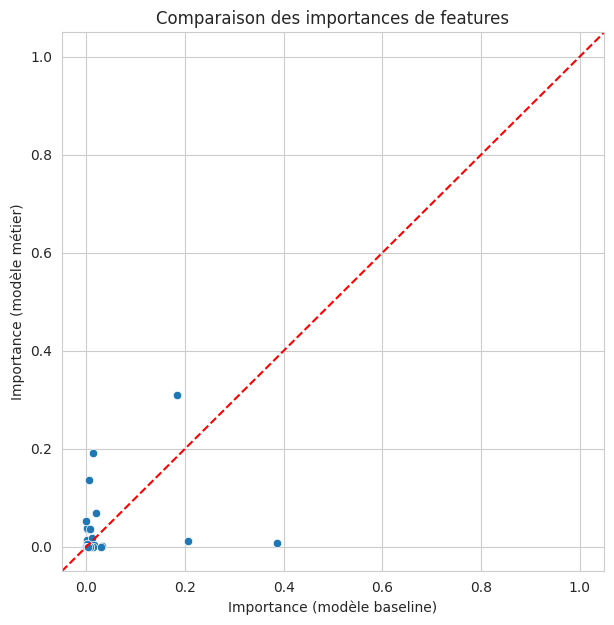

In [238]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    data=compare_importance,
    x="importance_baseline",
    y="importance_metier"
)
plt.axline((0,0), (1,1), color="red", linestyle="--")
plt.xlabel("Importance (modèle baseline)")
plt.ylabel("Importance (modèle métier)")
plt.title("Comparaison des importances de features")
plt.show()


In [239]:
# Score baseline
df_baseline = df_baseline.copy()
df_baseline["score_baseline"] = pipe_baseline.predict(X_baseline)

# Score modèle métier
df_metier = df_metier.copy()
df_metier["score_metier"] = pipe_metier.predict(X_metier)

# Merge par siren
scores_compare = df_metier[["siren", "signal_target_norm", "score_metier"]].merge(
    df_baseline[["siren", "score_baseline"]],
    on="siren",
    how="inner"
)

scores_compare.head()


,siren,signal_target_norm,score_metier,score_baseline
0,015751530,1.984521,1.984238,1.570813
1,046580031,-0.174781,-0.173995,-0.047167
2,057504649,-0.346430,-0.341355,-0.526520
3,086781150,-0.263058,-0.251011,-0.610758
4,096780838,-0.305383,-0.261173,-0.377117


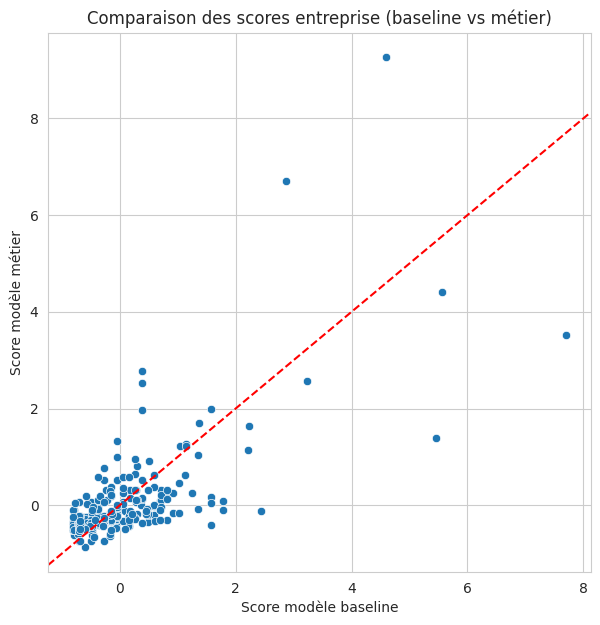

Corrélation baseline vs métier : 0.7045099774353811


In [240]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    data=scores_compare,
    x="score_baseline",
    y="score_metier"
)
plt.axline((0,0), (1,1), color="red", linestyle="--")
plt.xlabel("Score modèle baseline")
plt.ylabel("Score modèle métier")
plt.title("Comparaison des scores entreprise (baseline vs métier)")
plt.show()

corr = scores_compare[["score_baseline", "score_metier"]].corr().iloc[0,1]
print("Corrélation baseline vs métier :", corr)


In [241]:
scores_compare["delta_score"] = scores_compare["score_metier"] - scores_compare["score_baseline"]

# Sur-valorisés par le modèle métier
top_sur = scores_compare.sort_values("delta_score", ascending=False).head(10)

# Sous-valorisés par le modèle métier (donc plus forts dans le baseline)
top_sous = scores_compare.sort_values("delta_score").head(10)

print("Entreprises sur-valorisées par la logique métier :")
display(top_sur)

print("Entreprises sur-valorisées par la logique data (baseline) :")
display(top_sous)


Entreprises sur-valorisées par la logique métier :


,siren,signal_target_norm,score_metier,score_baseline,delta_score
219,538866740,9.288687,9.263330,4.588228,4.675102
208,518802459,6.688305,6.696051,2.863444,3.832607
161,431930932,2.796806,2.785681,0.388794,2.396887
134,401739917,2.533733,2.518409,0.384017,2.134392
206,514261320,1.940123,1.964776,0.382629,1.582146
106,381164342,1.323216,1.334575,-0.039616,1.374191
209,519017024,0.987708,0.992445,-0.050223,1.042668
184,480057298,0.785980,0.764710,-0.262663,1.027372
136,403785033,0.584652,0.577446,-0.369632,0.947078
258,888740297,0.054661,0.049344,-0.770265,0.819609


Entreprises sur-valorisées par la logique data (baseline) :


,siren,signal_target_norm,score_metier,score_baseline,delta_score
204,509935151,3.523028,3.516270,7.699404,-4.183134
217,534948617,1.370059,1.390631,5.452835,-4.062203
189,491129813,-0.101218,-0.109735,2.431123,-2.540858
26,317563054,-0.419994,-0.414421,1.569301,-1.983722
25,317193183,-0.101218,-0.103443,1.784496,-1.887938
128,397702093,0.099857,0.081690,1.786701,-1.705011
244,782190052,0.031197,0.041172,1.568764,-1.527592
222,542076633,-0.179686,-0.074826,1.343848,-1.418674
94,351421037,0.193038,0.176057,1.568432,-1.392376
197,501591762,-0.164973,-0.167893,1.030463,-1.198356


In [242]:
goldens = ["509935151","636220220","538866740","518802459","375980075","444323893","419239181"]
chevres = ["534948617","393891825","418480687"]

print("GOLDENS — baseline vs métier")
display(
    scores_compare[scores_compare["siren"].isin(goldens)]
    .sort_values("signal_target_norm", ascending=False)
)

print("CHEVRES — baseline vs métier")
display(
    scores_compare[scores_compare["siren"].isin(chevres)]
    .sort_values("signal_target_norm", ascending=False)
)


GOLDENS — baseline vs métier


,siren,signal_target_norm,score_metier,score_baseline,delta_score
219,538866740,9.288687,9.263330,4.588228,4.675102
208,518802459,6.688305,6.696051,2.863444,3.832607
228,636220220,4.405794,4.405288,5.562457,-1.157169
204,509935151,3.523028,3.516270,7.699404,-4.183134
173,444323893,0.570521,0.579945,0.054142,0.525803
97,375980075,0.563755,0.908880,0.510648,0.398232
150,419239181,-0.125739,-0.152068,-0.167102,0.015034


CHEVRES — baseline vs métier


,siren,signal_target_norm,score_metier,score_baseline,delta_score
217,534948617,1.370059,1.390631,5.452835,-4.062203
126,393891825,0.243830,0.622980,1.123713,-0.500733
148,418480687,-0.557313,-0.587440,-0.166911,-0.420529


In [243]:
def extract_code_from_feature(feat):
    # ex: "F_6_Croissance" -> "F"
    return feat.split("_")[0]

compare_importance["code_signal"] = compare_importance["feature"].apply(extract_code_from_feature)
compare_importance["def_signal"] = compare_importance["feature"]

importance_par_code = (
    compare_importance
    .groupby("code_signal")[["def_signal", "importance_baseline", "importance_metier"]]
    .sum()
    .reset_index()
)

importance_par_code["delta"] = (
    importance_par_code["importance_metier"] - importance_par_code["importance_baseline"]
)

importance_par_code.sort_values("delta", ascending=False)


,code_signal,def_signal,importance_baseline,importance_metier,delta
4,F,F_6_CroissanceF_6_Développement de l'activité,1.971664e-01,0.500147,0.302981
1,B,B_2_Construction,4.404670e-03,0.135689,0.131284
12,N,N_14_Recrutement,1.866276e-02,0.068815,0.050152
24,Z3,Z3_33_Politique RH & RSE,2.147731e-04,0.038537,0.038322
3,E,E_5_Création & ouvertureE_5_Créations & ouvert...,4.637499e-03,0.039976,0.035339
18,W,W_23_Foncier & bâti,1.309658e-03,0.035620,0.034311
27,recency,recency_jours,6.782796e-03,0.035354,0.028571
6,H,H_8_Activité internationale (tertiaire),1.975091e-03,0.012899,0.010924
5,G,G_7_Déménagement,1.514473e-03,0.010976,0.009462
9,K1,K1_32_Investissements,1.172199e-02,0.018321,0.006599


Delta positif → La logique métier augmente ce signal par rapport à ce que disent les données

Delta négatif → La logique data-driven considère ce signal plus important que ce que le métier pense

#### Faut-il pondérer ou supprimer le poids pour diversité et Hbis ?

🟦 Ce que le modèle baseline (data-driven) dit :

Les signaux les plus prédictifs sont Hbis (international) et diversité des signaux.

Les entreprises avec beaucoup de signaux variés et internationaux montent très haut, même si ce ne sont pas des prospects pertinents (ex : certaines chèvres).

➡️ Cela explique pourquoi certains chèvres avaient un score fort dans le baseline.


🟩 Ce que le modèle métier corrige :

La grille métier revalorise clairement construction, foncier, création, croissance, recrutement

Ce sont des signaux rares mais très “hautement qualitatifs”

Elle réduit l’effet bruit / volume / diversification

➡️ Le modèle métier classe beaucoup mieux les GOLDENS et abaisse les chèvres.


## rerun sans diversité sur le modèle baseline

In [244]:
features_baseline_v2 = [
    col for col in features
    if col not in ["diversite_signaux", "diversite", "nb_signaux_total", "nb"]
]
X_baseline_v2 = df_baseline[features_baseline_v2]

model_tree_without_div = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
pipe_baseline_v2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_tree_without_div)
])

pipe_baseline_v2.fit(X_baseline_v2, y)

df_baseline = df_baseline.copy()
df_baseline["score_baseline_v2"] = pipe_baseline_v2.predict(X_baseline_v2)

In [245]:
print(len(features), "features dans baseline v1")
print(len(features_baseline_v2), "features dans baseline v2 (sans diversité / nb)")

42 features dans baseline v1
41 features dans baseline v2 (sans diversité / nb)


In [246]:
model_base_v2 = pipe_baseline_v2.named_steps["model"]

importance_base_v2 = (
    pd.DataFrame({
        "feature": X_baseline_v2.columns,
        "importance_baseline_v2": model_base_v2.feature_importances_
    })
    .sort_values("importance_baseline_v2", ascending=False)
)

display(importance_base_v2.head(5))

,feature,importance_baseline_v2
10,Hbis_24_Activité internationale (industrie),0.378370
7,F_6_Développement de l'activité,0.148040
14,"L_12_Levée de fonds, financements & modifs. ca...",0.059639
16,N_14_Recrutement,0.046880
40,nb_signaux_10y,0.037673


In [247]:
scores_compare = df_metier[["siren", "signal_target_norm", "score_metier"]].merge(
    df_baseline[["siren", "score_baseline", "score_baseline_v2"]],
    on="siren",
    how="inner"
)
scores_compare

,siren,signal_target_norm,score_metier,score_baseline,score_baseline_v2
0,015751530,1.984521,1.984238,1.570813,1.568376
1,046580031,-0.174781,-0.173995,-0.047167,0.007161
2,057504649,-0.346430,-0.341355,-0.526520,-0.549065
3,086781150,-0.263058,-0.251011,-0.610758,-0.632962
4,096780838,-0.305383,-0.261173,-0.377117,-0.395705
...,...,...,...,...,...
261,901761114,-0.316572,-0.330037,-0.683537,-0.640494
262,916420128,-0.106122,-0.106453,0.696671,0.644040
263,927050013,-0.140452,-0.104036,-0.485291,-0.523169
264,947351656,-0.297388,-0.298324,0.702841,0.690763


In [248]:
goldens = ["509935151","636220220","538866740","518802459","375980075","444323893","419239181"]
chevres = ["534948617","393891825","418480687"]

print("GOLDENS — baseline_v1 vs baseline_v2 vs métier")
display(
    scores_compare[scores_compare["siren"].isin(goldens)]
)

print("CHEVRES — baseline_v1 vs baseline_v2 vs métier")
display(
    scores_compare[scores_compare["siren"].isin(chevres)]
)


GOLDENS — baseline_v1 vs baseline_v2 vs métier


,siren,signal_target_norm,score_metier,score_baseline,score_baseline_v2
97,375980075,0.563755,0.908880,0.510648,0.592050
150,419239181,-0.125739,-0.152068,-0.167102,-0.227047
173,444323893,0.570521,0.579945,0.054142,0.017048
204,509935151,3.523028,3.516270,7.699404,7.695206
208,518802459,6.688305,6.696051,2.863444,2.865341
219,538866740,9.288687,9.263330,4.588228,4.588248
228,636220220,4.405794,4.405288,5.562457,5.565582


CHEVRES — baseline_v1 vs baseline_v2 vs métier


,siren,signal_target_norm,score_metier,score_baseline,score_baseline_v2
126,393891825,0.243830,0.622980,1.123713,0.496824
148,418480687,-0.557313,-0.587440,-0.166911,-0.179187
217,534948617,1.370059,1.390631,5.452835,5.452575


In [249]:
compare_importance_v2 = (
    importance_base_v2
    .merge(importance_met, on="feature", how="outer")
    .fillna(0)
)

compare_importance_v2["delta_importance"] = (
    compare_importance_v2["importance_metier"] - compare_importance_v2["importance_baseline_v2"]
)

compare_importance_v2.head()


,feature,importance_baseline_v2,importance_metier,delta_importance
0,A_1_Aménagement & urbanisme,0.000251,0.000074,-0.000177
1,B_2_Construction,0.011460,0.135689,0.124229
2,D_4_Litige,0.000141,0.002831,0.002690
3,D_4_Litiges,0.000447,0.000563,0.000116
4,E_5_Création & ouverture,0.000627,0.002866,0.002239


In [250]:
compare_importance_v2["code_signal"] = compare_importance_v2["feature"].apply(extract_code_from_feature)
compare_importance_v2["def_signal"] = compare_importance_v2["feature"]

importance_par_code_v2 = (
    compare_importance_v2
    .groupby("code_signal")
    .agg({
        "importance_baseline_v2": "sum",
        "importance_metier": "sum",
        "def_signal": "first"
    })
    .reset_index()
)

In [251]:
# baseline v1 : delta_v1 = métier - baseline_v1
importance_par_code["delta_v1"] = (
    importance_par_code["importance_metier"] - importance_par_code["importance_baseline"]
)

# baseline v2 : delta_v2 = métier - baseline_v2
importance_par_code_v2["delta_v2"] = (
    importance_par_code_v2["importance_metier"] - importance_par_code_v2["importance_baseline_v2"]
)

In [252]:
ipc1 = importance_par_code[[
    "code_signal",
    "importance_baseline",
    "importance_metier",
    "delta_v1"
]]

ipc2 = importance_par_code_v2[[
    "code_signal",
    "importance_baseline_v2",
    "delta_v2"
]]

In [253]:
compare_codes_all = ipc1.merge(
    ipc2,
    on="code_signal",
    how="outer"
)

In [254]:
compare_codes_all.sort_values("delta_v2", ascending=False)

,code_signal,importance_baseline,importance_metier,delta_v1,importance_baseline_v2,delta_v2
4,F,1.971664e-01,0.500147,0.302981,0.148503,0.351644
1,B,4.404670e-03,0.135689,0.131284,0.011460,0.124229
18,W,1.309658e-03,0.035620,0.034311,0.001062,0.034558
3,E,4.637499e-03,0.039976,0.035339,0.005763,0.034214
27,recency,6.782796e-03,0.035354,0.028571,0.005872,0.029482
12,N,1.866276e-02,0.068815,0.050152,0.046880,0.021935
25,diversite,2.064180e-01,0.010777,-0.195641,0.000000,0.010777
6,H,1.975091e-03,0.012899,0.010924,0.005085,0.007814
24,Z3,2.147731e-04,0.038537,0.038322,0.033051,0.005486
13,O,5.180102e-03,0.003810,-0.001370,0.000579,0.003231


### vizu SHAP

In [255]:
import shap
shap.initjs()

In [256]:
# Baseline v1
X_baseline = df_baseline[features]
# Baseline v2 (sans diversité)
X_baseline_v2 = df_baseline[features_baseline_v2]
# Modèle métier
X_metier = df_metier[features_list]

# garder que les colonnes numériques
X_baseline = X_baseline.select_dtypes(include=[np.number])
X_baseline_v2 = X_baseline_v2.select_dtypes(include=[np.number])
X_metier = X_metier.select_dtypes(include=[np.number])

# Choix instance à expliquer
i = 0
x0_baseline = X_baseline.iloc[[i]]
x0_baseline_v2 = X_baseline_v2.iloc[[i]]
x0_metier = X_metier.iloc[[i]]

# Prédictions pour instance
prediction_baseline = pipe_xgb.predict(x0_baseline)
prediction_baseline_v2 = pipe_baseline_v2.predict(x0_baseline_v2)
prediction_baseline_metier = pipe_metier.predict(x0_metier)

In [257]:
# Explainers sur les models
explainer_baseline = shap.Explainer(model_tree_baseline)
explainer_baseline_v2 = shap.Explainer(model_tree_without_div)
explainer_baseline_metier = shap.Explainer(model_tree_metier)

# Valeurs de SHAP pour la même instance qu'au dessus
shap_values_baseline = explainer_baseline(x0_baseline)
shap_values_baseline_v2 = explainer_baseline_v2(x0_baseline_v2)
shap_values_baseline_metier = explainer_baseline_metier(x0_metier)


In [258]:
# Have a look at these values
#print(f"{'Base value:':<35}{shap_values_baseline.base_values[0]:>7.3f}{' Base value:':<35}{shap_values_baseline.base_values[0]:>7.3f}")
print(f"{'Base value - Baseline:':<35}{shap_values_baseline.base_values[0]:>7.3f}{', Baseline without diversity':<35}{shap_values_baseline_v2.base_values[0]:>7.3f}{', Baseline metier':<35}{shap_values_baseline_metier.base_values[0]:>7.3f}")
print(f"{'Sum of SHAP values - Baseline:':<35}{shap_values_baseline.values.sum():>7.3f}{', Baseline without diversity:':<35}{shap_values_baseline_v2.values.sum():>7.3f}{', Baseline metier:':<35}{shap_values_baseline_metier.values.sum():>7.3f}")
print(f"{'The prediction for this instance - Baseline:':<35}{prediction_baseline[0]:>7.3f}{', Baseline without diversity:':<35}{prediction_baseline_v2[0]:>7.3f}{', Baseline metier:':<35}{prediction_baseline_metier[0]:>7.3f}")

Base value - Baseline:               0.042, Baseline without diversity         0.001, Baseline metier                    0.018
Sum of SHAP values - Baseline:       2.622, Baseline without diversity:        1.916, Baseline metier:                   3.127
The prediction for this instance - Baseline:  1.571, Baseline without diversity:        1.568, Baseline metier:                   1.984


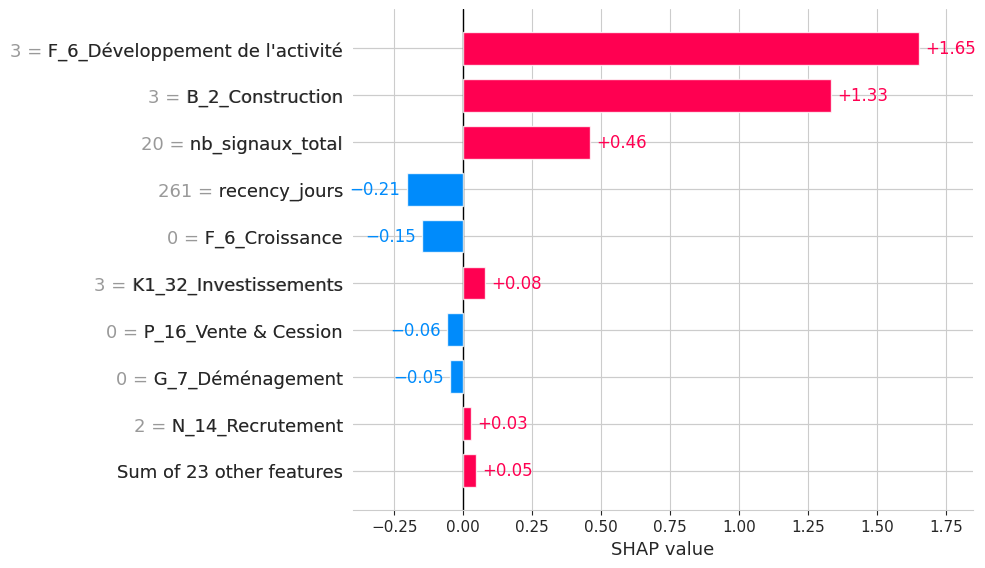

In [259]:
shap.plots.bar(shap_values_baseline_metier[0])

In [260]:
shap.plots.force(shap_values_baseline_metier[0])

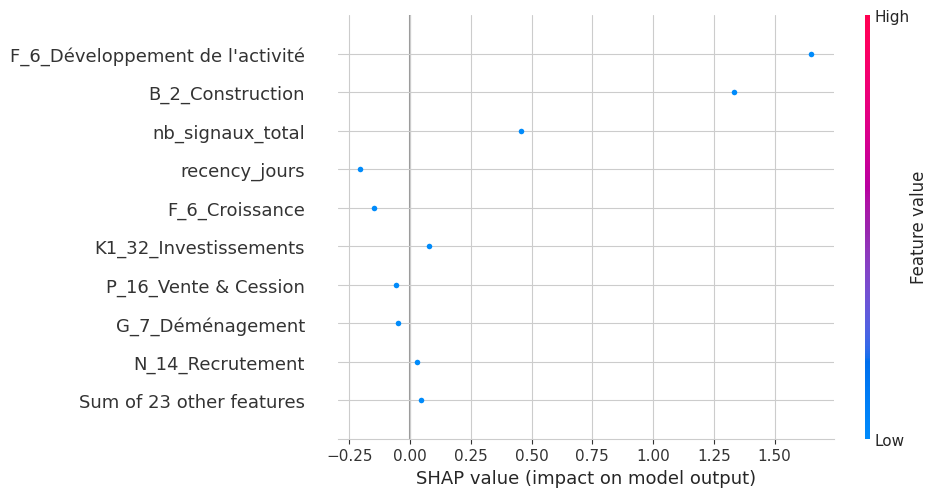

In [261]:
shap.plots.beeswarm(shap_values_baseline_metier)